# Speed Model

This code has a speed model that can help to determine how long a fit will take. The $\chi^2$ method does not take any appreciable time, but the Feldman-Cousin fit can take from a few minutes to many days depending on the parameters chosen for the fit.

## Parameters

The three parameters of interest for the FC method are the length of the independent variable (x length), the size of the grid (set in the chi2 method), and the number of monte-carlo resampling experiments (n_exp in the fc method). These parameters will be labeled $x$, $g_1, g_2$ and $n$ respectively.

## Predicting

The time to run as a function of the parameters is

$$
f(x, g_1, g_2, n) \propto x\cdot g_1 \cdot g_2 \cdot n
$$

The proportionality constant has to be found via experimentation, which will be shown below

In [1]:
import fc
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('seaborn')

In [2]:
model = norm.pdf

params = (5, .5)
x = np.linspace(norm.ppf(0.01, *params), norm.ppf(0.99, *params), 100)
y = norm.pdf(x, *params) + np.random.normal(0, .1, len(x))

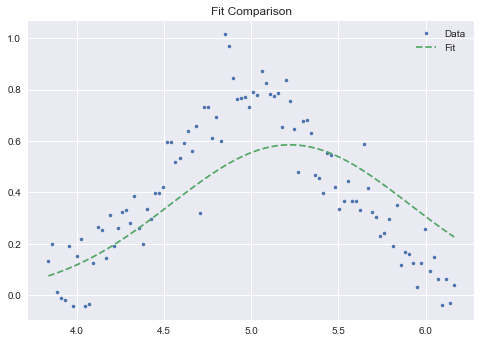

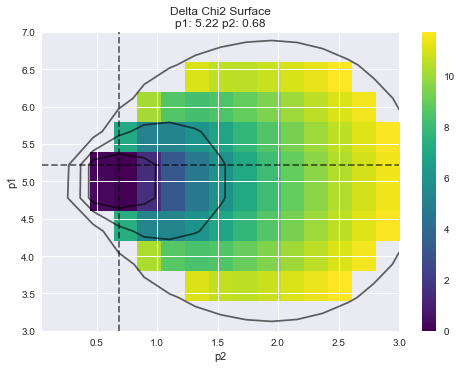

In [3]:
res = fc.fit(model, x, y, [3, 7], [0.05, 3], grid_size=[10, 15])
ext = (0.05, 3, 3, 7)

plt.title('Fit Comparison')
plt.plot(x, y, '.', label='Data')
plt.plot(x, res.best_fit, '--', label='Fit')
plt.legend()

plt.figure()
plt.title('Delta Chi2 Surface\np1: {:.2f} p2: {:.2f}'.format(*res.params))
plt.ylabel('p1')
plt.xlabel('p2')
surf = np.ma.masked_greater(res.dchi2_space, 11.83)
im = plt.imshow(surf, cmap='viridis', extent=ext, aspect='auto', origin='lower')
plt.contour(res.dchi2_space, [0, 2.3, 6.18, 11.83], colors='k', alpha=0.6, extent=ext)
plt.axhline(res.params[0], c='k', ls='--', alpha=0.6)
plt.axvline(res.params[1], c='k', ls='--', alpha=0.6)
plt.colorbar(im)

## Finding the constant

For this fit, we can see above the $x=100$, $g_1 = 10$, and $  g_2 = 15$
We will keep $n$ low to keep test reasonable, and let's time the fit. Note, if you use the verbose flag in the FC method it will automatically report the total time for the fitting.

In [4]:
dchi2 = res.fc(n_exp=20, verbose=True)

Time elapsed 46.23077974549324s


Now, we can find the constant by using the formula from above. For the constant we will use $\gamma$

In [5]:
T = 25.712956726106427 #seconds
grid = [10, 15]
n = 20
gamma = T / (len(x) * grid[0] * grid[1] * n)
print(gamma)

8.570985575368809e-05


## Conclusion

So, from our model and a single run we can estimate the fitting of the given model to be 

$$
f(x, g_1, g_2, n) = \gamma x\cdot g_1\cdot g_2 \cdot n = (8.571\cdot 10^{-5}) (x\cdot g_1\cdot g_2 \cdot n)
$$

So, we would estimate that the time to do the same model with 40 experiments should be

$$
f(100, 10, 15, 40) = (8.571\cdot 10^{-5}) (100 \cdot 10 \cdot 15 \cdot 40) = 51.43 s
$$

Let's see how accurate it is

In [6]:
dchi2_40= res.fc(40, verbose=True)

Time elapsed 90.03151724701915s


 So our accuracy is within the same order of magnitude, which is all we need to care about for deciding whether to run a model. This is useful, because we now can determine whether it is worth our time to fit a gaussian model using any parameters using the simple formula above. 
 
 ## Caveats
 The way the constant is found means that this model will only work for the exact model I defined in the beggining. For me, this was the norm.pdf from scipy. An important factor to consider is that the execution time will change based on the machine used, as well. Including small factors like leaving a laptop plugged in or not to run. For best accuracy with the model, do the timing test on the machine with the same environment you plan to run the fc fit in.

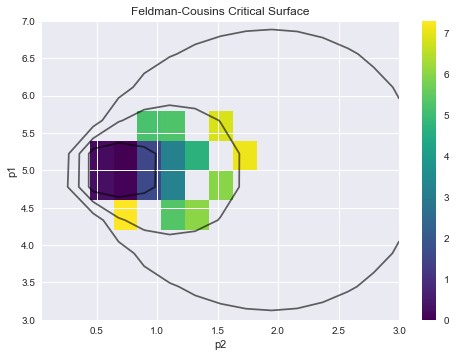

In [7]:
#mask original delta chi2 surface so that any values greater than the 95th percentile are excluded
final = res.get_surf(95)

plt.title('Feldman-Cousins Critical Surface')
im = plt.imshow(final, cmap='viridis', extent=ext, aspect='auto', origin='lower', interpolation='nearest')
plt.contour(res.dchi2_space, [0, 2.3, 6.8, 11.83], alpha=0.6, colors='k', extent=ext)
plt.ylabel('p1')
plt.xlabel('p2')
plt.colorbar(im)